<a href="https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JoaoLages/diffusers-interpret/blob/main/notebooks/stable_diffusion_inpaint_example.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion - Inpaint 🎨 

This notebook shows an example of how to run `diffusers_interpret.StableDiffusionInpaintPipelineExplainer` to explain `diffusers.StableDiffusionInpaintPipeline`.

In [1]:
#!pip install -U diffusers-interpret

### 0 - Login in HuggingFace's Hub

In [2]:
from huggingface_hub import notebook_login
notebook_login()

### 1 - Initialize `StableDiffusionInpaintPipeline` normally

In [3]:
# make sure you're logged in by running the previous cell or `huggingface-cli login`
import torch
from contextlib import nullcontext
import requests
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionInpaintPipeline


def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    use_auth_token=True,
    
    # FP16 is not working for 'cpu'
    revision='fp16' if device != 'cpu' else None,
    torch_dtype=torch.float16 if device != 'cpu' else None
).to(device)
pipe.enable_attention_slicing()

{'trained_betas'} was not found in config. Values will be initialized to default values.


### 2 - Pass `StableDiffusionInpaintPipeline` to `StableDiffusionInpaintPipelineExplainer`

In [4]:
from diffusers_interpret import StableDiffusionInpaintPipelineExplainer

explainer = StableDiffusionInpaintPipelineExplainer(pipe, gradient_checkpointing=True)

### 3 - Generate an image with the `StableDiffusionInpaintPipelineExplainer` object

Note that the `explainer()` method accepts all the arguments that `pipe()` accepts. 

We also pass a `generator` argument so that we get a deterministic output.

In [5]:
prompt = "a cat sitting on a bench"

img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((448, 448))
mask_image = download_image(mask_url).resize((448, 448))

generator = torch.Generator(device).manual_seed(9569)
with torch.autocast('cuda') if device == 'cuda' else nullcontext():
    output = explainer(
        prompt=prompt, init_image=init_image, mask_image=mask_image, strength=0.75, generator=generator
    )

  0%|          | 0/38 [00:00<?, ?it/s]

Calculating token and image pixel attributions... Done!


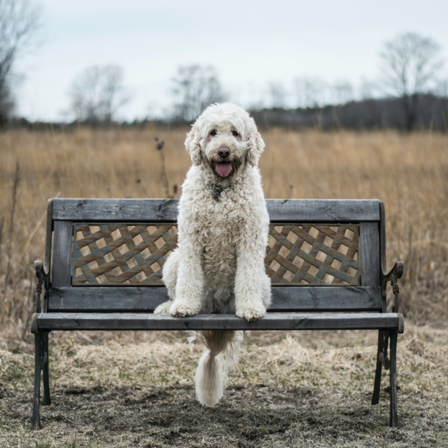

In [13]:
init_image

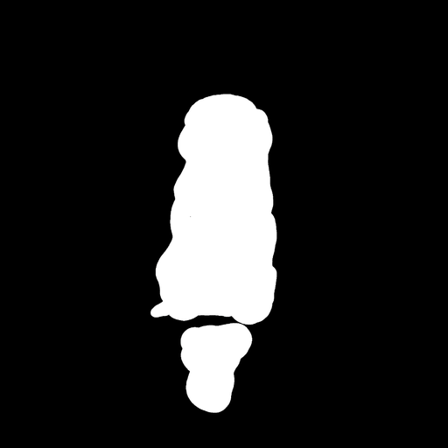

In [14]:
mask_image

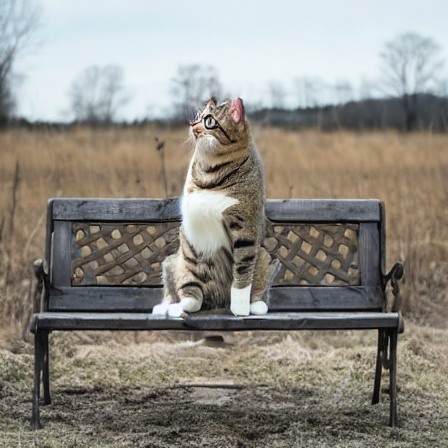

In [6]:
# Final image
output.image

#### 3.1 - Input Saliency Maps

It is now possible to visualize the computed pixel attributions in a saliency map

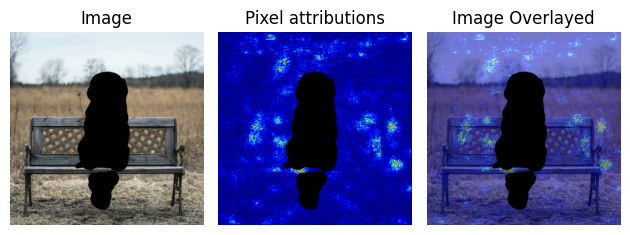

In [7]:
output.input_saliency_map.show(cmap='jet', image_weight=0.5)

Or access the pixel attributions directly

In [8]:
output.pixel_attributions.shape

(448, 448)

In [9]:
output.pixel_attributions

array([[ 0.9370117 ,  1.9501953 ,  1.2099609 , ...,  3.5996094 ,
         1.2578125 ,  1.421875  ],
       [ 1.3095703 ,  2.8066406 ,  1.1025391 , ...,  7.4179688 ,
         1.9550781 ,  2.1367188 ],
       [ 0.9482422 ,  1.9023438 ,  3.3300781 , ..., 11.9140625 ,
         5.46875   ,  4.0195312 ],
       ...,
       [ 2.6015625 ,  3.9257812 ,  4.1367188 , ..., 13.0625    ,
         3.2089844 ,  2.3671875 ],
       [ 2.6621094 ,  2.1464844 ,  7.015625  , ...,  3.9160156 ,
        12.3515625 ,  0.3864746 ],
       [ 0.50390625,  1.0927734 ,  4.3046875 , ...,  1.6894531 ,
         1.4003906 ,  1.0820312 ]], dtype=float32)

Or their normalized version

In [10]:
output.normalized_pixel_attributions

array([[3.27075286e-05, 6.80739249e-05, 4.22351513e-05, ...,
        1.25648716e-04, 4.39054675e-05, 4.96322682e-05],
       [4.57121350e-05, 9.79691904e-05, 3.84854575e-05, ...,
        2.58933171e-04, 6.82443642e-05, 7.45847574e-05],
       [3.30995426e-05, 6.64036124e-05, 1.16240401e-04, ...,
        4.15874762e-04, 1.90893348e-04, 1.40306598e-04],
       ...,
       [9.08106886e-05, 1.37034149e-04, 1.44397171e-04, ...,
        4.55962378e-04, 1.12013484e-04, 8.26295436e-05],
       [9.29241505e-05, 7.49256360e-05, 2.44888884e-04, ...,
        1.36693270e-04, 4.31146240e-04, 1.34903639e-05],
       [1.75894565e-05, 3.81445789e-05, 1.50260326e-04, ...,
        5.89724041e-05, 4.88823280e-05, 3.77696088e-05]], dtype=float32)

#### 3.2 - You still have access to all the features that exist in `StableDiffusionPipelineExplainer`

Here are some examples below. Find out more features in [this notebook](https://www.github.com/JoaoLages/diffusers-interpret/blob/main/notebooks/stable_diffusion_example.ipynb).

In [11]:
# (token, attribution_percentage)
output.normalized_token_attributions

[('a', 1.985),
 ('cat', 45.252),
 ('sitting', 11.798),
 ('on', 11.999),
 ('a', 7.157),
 ('bench', 21.809)]

In [12]:
# Google Colab does not render the IFrame from the code below, only works locally on your Jupyter Notebook.
output.all_images_during_generation.show(width="100%", height="400px")

###########################################################################################################################
# As an alternative to visualize the produced HTML, run:
#import os, shutil, diffusers_interpret
#shutil.copy2(os.path.join(os.path.dirname(diffusers_interpret.__file__), "dataviz", "image-slider", "final.html"), '.')

# and open the saved './final.html' manually